### AI Lab 4 - Reinforcement Learning with Q-Learning

*   Uses python & open AI's gym libarary

Some tasks you can try:
1.   Understand the code, change hyper-parameters & fine tune model
2.   Change environment to slippery (non-deterministic)
3.   Implement another environment from Open AI's gym (https://www.gymlibrary.dev/environments/toy_text/)


In [ ]:
%%capture
!pip install pyglet==1.5.1
!apt install python-opengl
!apt install ffmpeg
!apt install xvfb
!pip3 install pyvirtualdisplay

# Virtual display
from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

In [ ]:
%%capture
!pip install gym==0.24
!pip install pygame
!pip install numpy

!pip install imageio imageio_ffmpeg

In [ ]:
import numpy as np
import gym
import random
import imageio
from tqdm.notebook import trange

This specific environment "FrozenLake-v1" represents a 4x4 grid where the agent starts in the top-left corner and must navigate to the bottom-right corner. The agent can take 4 four actions: up, down, left, or right.

https://www.gymlibrary.dev/environments/toy_text/frozen_lake/

In [ ]:
env = gym.make("FrozenLake-v1",map_name="4x4",is_slippery=False)

print("Observation Space", env.observation_space)
print("Sample observation", env.observation_space.sample()) # display a random observation

Observation Space Discrete(16)
Sample observation 3


Python code to get visualisation working in Google Colab

In [ ]:
def record_video(env, Qtable, out_directory, fps=1):
  images = [] 
  done = False
  state = env.reset(seed=random.randint(0,500))
  img = env.render(mode='rgb_array')
  images.append(img)
  while not done:
    # Take the action (index) that have the maximum expected future reward given that state
    action = np.argmax(Qtable[state][:])
    state, reward, done, info = env.step(action) # We directly put next_state = state for recording logic
    img = env.render(mode='rgb_array')
    images.append(img)
  imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

See Sample Space

In [ ]:
print("Action Space Shape", env.action_space.n)
print("Action Space Sample", env.action_space.sample())

n_actions = env.action_space.n

# Print all the possible actions
for i in range(n_actions):
    print(i, end=", ")

Action Space Shape 4
Action Space Sample 3
0, 1, 2, 3, 

In [ ]:
state_space = env.observation_space.n
print("There are ", state_space, " possible states")

action_space = env.action_space.n
print("There are ", action_space, " possible actions")

There are  16  possible states
There are  4  possible actions


Create Q Table

A Q-table is a data structure that is used to store the Q-values (i.e. the estimated action values) for each state-action pair in a reinforcement learning problem.

In the case of the "FrozenLake-v1" environment, the Q-table would have the shape of (nS, nA) where nS is the number of states and nA is the number of actions. Since the grid is a 4x4, there are 16 states, and the agent can move in 4 directions, there would be 4 actions. So the Q-table would have shape (16, 4).

Each entry in the Q-table represents the Q-value for a specific state-action pair, i.e. the expected cumulative reward of taking a specific action in a specific state and following the optimal policy afterwards.

So for example, the Q-value for the state-action pair (s, a) = (0, 1) would represent the expected cumulative reward for taking action 1 (i.e. moving right) in state 0 (i.e. the top-left corner) and following the optimal policy from there.

In [ ]:
def initialize_q_table(state_space, action_space):
  #create grid for q-values that match the game to be played
  Qtable = np.zeros((state_space, action_space))
  return Qtable

Qtable_frozenlake = initialize_q_table(state_space, action_space)

In [ ]:
Qtable_frozenlake

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

Before Learning! Just goes left all the time, looses after time limit is up!

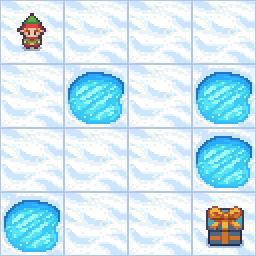

In [ ]:
video_path="/content/replay.gif"
video_fps=1
record_video(env, Qtable_frozenlake, video_path, video_fps)

from IPython.display import Image
Image('./replay.gif')

In [ ]:
def epsilon_greedy_policy(Qtable, state, epsilon):
  random_int = random.uniform(0,1)
  if random_int > epsilon:
    action = np.argmax(Qtable[state])
  else:
    action = env.action_space.sample()
  return action

In [ ]:
def greedy_policy(Qtable, state):
  action = np.argmax(Qtable[state])
  return action

In [ ]:
# Training parameters
n_training_episodes = 10000
learning_rate = 0.7  

# Evaluation parameters
n_eval_episodes = 100      

# Environment parameters
env_id = "FrozenLake-v1"   
max_steps = 99             
gamma = 0.95               
eval_seed = []             

# Exploration parameters
max_epsilon = 1.0           
min_epsilon = 0.05           
decay_rate = 0.0005           

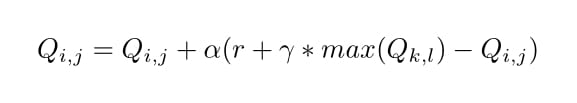

In [ ]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
  for episode in trange(n_training_episodes):
 
    # decay the epsilon value. This maximises exploration in the start of training, but then starts to be more picky and only starts to pick
    # the best value after it has experienced enough. 
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)

    # Reset the environment
    state = env.reset()
    step = 0
    done = False

    # repeat
    for step in range(max_steps):
   
      # Look into future & select action based on epsilon greedy-policy from the current q-table
      action = epsilon_greedy_policy(Qtable, state, epsilon)
      new_state, reward, done, info = env.step(action)

      Qtable[state][action] = Qtable[state][action] + learning_rate * (reward + gamma * np.max(Qtable[new_state]) - Qtable[state][action])

      # If done, finish the episode
      if done:
        break
     
      # Our state is the new state
      state = new_state
  return Qtable

In [ ]:
Qtable_frozenlake = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable_frozenlake)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
Qtable_frozenlake

array([[0.73509189, 0.77378094, 0.77378094, 0.73509189],
       [0.73509189, 0.        , 0.81450625, 0.77378094],
       [0.77378094, 0.857375  , 0.77378094, 0.81450625],
       [0.81450625, 0.        , 0.77378094, 0.77378094],
       [0.77378094, 0.81450625, 0.        , 0.73509189],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9025    , 0.        , 0.81450625],
       [0.        , 0.        , 0.        , 0.        ],
       [0.81450625, 0.        , 0.857375  , 0.77378094],
       [0.81450625, 0.9025    , 0.9025    , 0.        ],
       [0.857375  , 0.95      , 0.        , 0.857375  ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9025    , 0.95      , 0.857375  ],
       [0.9025    , 0.95      , 1.        , 0.9025    ],
       [0.        , 0.        , 0.        , 0.        ]])

In [ ]:
def evaluate_agent(env, max_steps, n_eval_episodes, Q, seed):

  episode_rewards = []
  for episode in range(n_eval_episodes):
    if seed:
      state = env.reset(seed=seed[episode])
    else:
      state = env.reset()
    step = 0
    done = False
    total_rewards_ep = 0
   
    for step in range(max_steps):
      # Take the action (index) that have the maximum reward (i.e. play the move in the game with the best expected reward in a greedy fashion)
      action = np.argmax(Q[state][:])
      new_state, reward, done, info = env.step(action)
      total_rewards_ep += reward
       
      if done:
        break
      state = new_state
    episode_rewards.append(total_rewards_ep)
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward

In [ ]:
# Evaluate our Agent
mean_reward, std_reward = evaluate_agent(env, max_steps, n_eval_episodes, Qtable_frozenlake, eval_seed)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")

Mean_reward=1.00 +/- 0.00


E.g. "Mean_reward=1.00 +/- 0.00" indicates that the learned agent with Q-learning received an average reward of 1.00 per episode, and that its performance was consistent across all evaluated episodes. (i.e. it won every time it played)

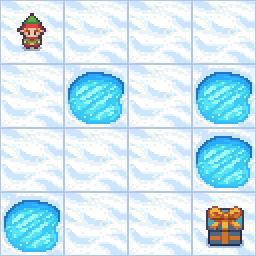

In [ ]:
video_path="/content/replay.gif"
video_fps=1
record_video(env, Qtable_frozenlake, video_path, video_fps)

from IPython.display import Image
Image('./replay.gif')